### Project : Roadmap
->Connecting with db <br>
->dtype<br>
->values <br>
->outlier<br>
->statistical test <br>
->significance.<br>
->outliers<br>
->segmentations<br>



### Importing the Prerequisities

In [2]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import seaborn as sns
import re
from scipy import stats
import datetime
from scipy.stats import normaltest,chi2_contingency
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
np.random.seed(42)
import warnings
warnings.filterwarnings('ignore')

### Connecting With SSMS 

In [ ]:

# cnxn = pyodbc.connect("DRIVER={ODBC Driver 17 for SQL Server};"
#                       "Server=NAV-ABU;"
#                       "Database=Live in Lab;"
#                       "Trusted_Connection=yes;")

### Querying the data

In [4]:
# df = pd.read_sql_query('select * from shopping_trends',cnxn)

In [5]:
# data = df.copy()
df = pd.read_csv('data.csv')
data = df.copy()
df.head()

,Unnamed: 0,identifierHash,type,country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,...,civilityTitle,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,seniorityAsMonths,seniorityAsYears,countryCode
0,0,-7279641312655250028,user,Etats-Unis,en,3,8,0,0,0,...,mrs,False,False,False,True,709,3205,106.830002,8.9,us
1,1,-1456013578740053406,user,Allemagne,de,3,8,0,0,0,...,mrs,False,False,False,True,709,3205,106.830002,8.9,de
2,2,9006282053848196165,user,Suède,en,3,8,0,0,0,...,mr,True,False,True,True,689,3205,106.830002,8.9,se
3,3,-7154634866120535654,user,Turquie,en,3,8,0,0,0,...,mrs,False,False,False,True,709,3205,106.830002,8.9,tr
4,4,2858299215060733023,user,France,en,3,8,0,0,0,...,mr,True,False,True,True,709,3205,106.830002,8.9,fr


In [6]:
for col in data.columns:
    if data[col].nunique()> data.shape[0]*0.69:
        df.drop(col,axis=1,inplace=True)

### Data Type Correction

In [7]:
patterns = {
    'date': [r'\d{4}-\d{2}-\d{2}', r'\d{2}/\d{2}/\d{4}', r'\d{2}-\d{2}-\d{4}'],
    'percentage': [r'\d+%'],
    'int':[r'\d+'],
    'price': [r'\$\d+', r'\d+\.\d{2}', r'\d+,\d+']
}

In [8]:
def correct_dtype(patterns):
    dtypes = df.dtypes.tolist()
    cols = df.columns.tolist()
    for i in range(len(cols)):
        df[cols] = df[cols].replace('',np.nan)
        if dtypes[i] == 'object':
            sam = df[cols[i]].unique()[0]
            cor,m='',0
            for dtype,pats in patterns.items():
                for pat in pats:
                    l=re.match(pat,str(sam)) 
                    if l!=None and l>m:
                        m=l
                        cor=dtype
            if cor == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]],errors='coerce')
            elif cor == 'percentage':
                df[cols[i]] = df[cols[i]].str.replace('%','').astype('float')
            elif cor == 'int':
                df[cols[i]] = pd.to_numeric(df[cols[i]],errors='coerce')
            elif cor == 'price':
                df[cols[i]] = df[cols[i]].str.replace('$','').replace(',','').astype('float')
                
                

### Handling Missing values

In [9]:
def handle_null(impute=False):
    col_nulls = df.isnull().sum()
    nulls_50 = []
    impute_num = []
    impute_cat = []
    for col,null in col_nulls.items():
        if null==0:
            continue
        if null>df.shape[0]*0.5:
            nulls_50.append(col)
            continue
        elif impute:
            if 'int' in str(df[col].dtypes):
                impute_num.append(col)
            else:
                impute_cat.append(col)
    df.drop(nulls_50,axis=1,inplace=True)
    return nulls_50,impute_num,impute_cat   

In [10]:
def imputer():
    drop,im_num,im_cat=handle_null(True)
    
    rfr = RandomForestRegressor()
    rfc = RandomForestClassifier()
    
    X = df[df.select_dtypes(include=['int','float']).columns]
    imputer_num = IterativeImputer(estimator = rfr,max_iter=100)
    df[df.select_dtypes(include=['int','float']).columns] = imputer_num.transform(X)
    
    for col in im_cat:
        imputer_cat = IterativeImputer(estimator = rfc)
        le = LabelEncoder()
        y = le.fit_transform(df[col])
        X = df[df.select_dtypes(include=['int','float']).columns]
        imputer_cat.fit(X,y=y)
        y = imputer_cat.transform(X)
        df[col] = le.inverse_transform(y.round().astype('int'))

### EDA

In [11]:
description_of_data = {}
features_dtypes_missing_values = {}
statistical_results = {}
correlation = {}
data_facts_and_cubes = {}
visuals_data_cubes = {}
visuals_hist_bins = {}
visuals_count = {}
outliers = {}

In [12]:
description_of_data = df.describe().to_dict()

In [13]:
null = df.isnull().sum()
fetaures = df.columns
dtypes = df.dtypes.to_dict()
for col,n,dt in zip(df.columns,null,dtypes):
    features_dtypes_missing_values[col] =  {'missing_values':n,'dtypes':dt}

In [14]:
num_cols = df.select_dtypes(include=['int','float']).columns
cat_cols = df.select_dtypes(exclude=['int','float']).columns
num_cols

Index(['socialNbFollowers', 'socialNbFollows', 'socialProductsLiked',
       'productsListed', 'productsSold', 'productsPassRate', 'productsWished',
       'productsBought', 'civilityGenderId', 'daysSinceLastLogin', 'seniority',
       'seniorityAsMonths', 'seniorityAsYears'],
      dtype='object')

In [15]:
correlation = df[num_cols].corr()

In [16]:
# stats.shapiro(df[num_cols[1]])
for col in num_cols:
    statistical_results[col+' '+'Shapiro test'] = stats.shapiro(df[col])

In [17]:
def chi_square_test(A,B):
    contingency_table = pd.crosstab(A,B)
    return  chi2_contingency(contingency_table)

In [18]:
ALPHA = 0.05
chi = []
for prev_col in range(len(cat_cols)):
    for cur_col in range(prev_col+1,len(cat_cols)):
        chi2_stat, p_val, dof, ex = chi_square_test(df[cat_cols[prev_col]],df[cat_cols[cur_col]])
        res = f""" feature 1:{cat_cols[prev_col]} and feature 2: {cat_cols[cur_col]}
        Chi-Square Statistic: {chi2_stat}
        p-value: {p_val}
        Degrees of freedom:{dof}
        Expected frequencies:{ex}"""
        if p_val <= ALPHA:
            print(f'Rejected H0 under significance level {ALPHA} {cat_cols[prev_col]} & {cat_cols[cur_col]} are dependent.')
            res+=f'\nRejected H0 under significance level {ALPHA} {cat_cols[prev_col]} & {cat_cols[cur_col]} are dependent.'
        else:
            print(f'Fail to reject H0 due to lack of evidence under significance level {ALPHA} {cat_cols[prev_col]} & {cat_cols[cur_col]} are independent.')
            res+=f'\nFail to reject H0 due to lack of evidence under significance level {ALPHA} {cat_cols[prev_col]} & {cat_cols[cur_col]} are independent.'
        chi.append(res)

Fail to reject H0 due to lack of evidence under significance level 0.05 type & country are independent.
Fail to reject H0 due to lack of evidence under significance level 0.05 type & language are independent.
Fail to reject H0 due to lack of evidence under significance level 0.05 type & gender are independent.
Fail to reject H0 due to lack of evidence under significance level 0.05 type & civilityTitle are independent.
Fail to reject H0 due to lack of evidence under significance level 0.05 type & hasAnyApp are independent.
Fail to reject H0 due to lack of evidence under significance level 0.05 type & hasAndroidApp are independent.
Fail to reject H0 due to lack of evidence under significance level 0.05 type & hasIosApp are independent.
Fail to reject H0 due to lack of evidence under significance level 0.05 type & hasProfilePicture are independent.
Fail to reject H0 due to lack of evidence under significance level 0.05 type & countryCode are independent.
Rejected H0 under significance lev

In [19]:
statistical_results['chi-square contigency test'] = chi

In [20]:
for col in cat_cols:
    # Observed frequencies
    obs = df[col].value_counts().values
    
  
    exp = np.full(len(obs), len(df) / len(obs), dtype='float')
    
    # Perform the Chi-square test
    chi2_stat, p_val = stats.chisquare(obs, exp)
    
    # Store results in the dictionary
    statistical_results[col + ' ' + 'Chi Square test'] = {'Chi2 Statistic': chi2_stat, 'p-value': p_val}

In [21]:
cols = num_cols.to_list()+cat_cols.to_list()
diff_cat_cols = []
for col in cat_cols:
    obs = df[col].value_counts().values
    exp = np.full_like(obs,len(df)/len(obs),dtype='float')
    p = np.round(stats.chisquare(obs,exp).pvalue,2)
    if p<0.05:
        data_facts_and_cubes[col] = df.groupby(col)[cat_cols].agg({'max','min',pd.Series.mode})
        data_facts_and_cubes[col] = df.groupby(col)[num_cols].agg({'max','count',pd.Series.mean})
        diff_cat_cols.append(col)

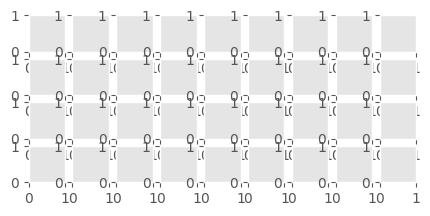

In [ ]:
plt.figure(figsize=(5,5))
plot_index = 1
for i in range(len(diff_cat_cols)-1):
    for j in range(i+1,len(diff_cat_cols)):
        grp_data = df.groupby([diff_cat_cols[i],diff_cat_cols[j]]).size().unstack().fillna(0)
        # plt.subplot(len(diff_cat_cols) , len(diff_cat_cols) , plot_index)
        # grp_data.plot(kind='bar')
        # plt.savefig('data_cube'+diff_cat_cols[i]+diff_cat_cols[j])
        visuals_data_cubes['data_cube'+diff_cat_cols[i]+diff_cat_cols[j]] = grp_data
        # plt.close()
        # print(grp_data)
        # plot_index+=1
# plt.tight_layout()

        
        # print(pd.DataFrame(grp_data))
        # print('-'*100)

In [23]:
visuals_data_cubes

{'data_cubecountrylanguage': language                       de     en    es    fr    it
 country                                                   
 Afghanistan                   2.0    4.0   0.0   4.0   0.0
 Afrique du Sud                0.0   83.0   0.0   0.0   0.0
 Albanie                       2.0   28.0   0.0   2.0   5.0
 Algérie                       4.0    9.0   0.0  63.0   0.0
 Allemagne                  5882.0  581.0  24.0  51.0  29.0
 ...                           ...    ...   ...   ...   ...
 Îles Féroé                    1.0    1.0   0.0   0.0   0.0
 Îles Malouines                0.0    0.0   0.0   1.0   0.0
 Îles Turques-et-Caïques       0.0    3.0   0.0   0.0   0.0
 Îles Vierges (U.S.)           1.0    2.0   0.0   0.0   0.0
 Îles Vierges britanniques     1.0    2.0   0.0   0.0   0.0
 
 [200 rows x 5 columns],
 'data_cubecountrygender': gender                          F       M
 country                                  
 Afghanistan                   5.0     5.0
 Afrique d

In [ ]:
# plt.figure(figsize=(10,5))
try:
    index = 0

    for col in num_cols:
        counts, bin_edges = np.histogram(df[num_cols[1]])
        # plt.subplot(len(num_cols)-1,len(num_cols)-1,index)
        # df[col].plot(kind='hist', title=f'Histogram of {num_cols[1]}', bins=bin_edges)
        # plt.xlabel(col)
        # plt.ylabel('Frequency')
        visuals_hist_bins['hist'+col] = {"counts":counts,"bin_edges":bin_edges}
        # plt.savefig('hist'+col)
        # plt.close()
        index+=1
except:
    pass

In [ ]:
# plt.figure(figsize=(20, 25))
index = 1
visuals_count = {}

for col in df.columns:
    if df[col].nunique() < 6:
        # plt.subplot(len(df.columns), len(df.columns), index)
        if str(df[col].dtype) != 'object':
            df[col].value_counts().plot(kind='pie', autopct='%1.1f%%')
            # plt.title(f'Pie chart for {col}')
            # plt.ylabel('')  # Hide the y-label for the pie chart
            # plt.savefig(f'pie {col}.png')
            # plt.close()
            visuals_count[f'pie {col}.png'] = df[col].value_counts().to_dict()
        else:
            # sns.countplot(data=df, y=col)
            # plt.title(f'Count plot for {col}')
            # plt.savefig(f'ctplot {col}.png')
            # plt.close()
            visuals_count[f'ctplot {col}.png'] = df[col].value_counts().to_dict()
        index += 1

In [ ]:
try:
    data_num = pd.get_dummies(df,dtype='float')
    data_num.dropna(inplace=True)
    mean_vector = np.mean(data_num, axis=0)  # (11,)
    if data_num.ndim != 2:
        raise ValueError("Input data must be a 2D array where rows are samples and columns are features.")
    # Calculate the covariance matrix
    cov_matrix = np.cov(data_num, rowvar=False)  # (11, 11)

    # Compute the inverse of the covariance matrix
    inv_cov_matrix = np.linalg.inv(cov_matrix)  # (11,11)

    # Define the Mahalanobis distance function
    def mahalanobis(x):
        centered_x = x - mean_vector  # (11,)
        mahalanobis_dist = np.dot(centered_x, np.dot(inv_cov_matrix, centered_x.T))  # (1,)
        return mahalanobis_dist
    data_num['mahalanobis'] = data_num.apply(lambda row: mahalanobis(row), axis=1)
    out_data = df.copy()
    out_data.dropna(inplace=True)
    out_data['outlier'] = [1 if i>(data_num['mahalanobis'].mean())*3  else 0 for i in data_num['mahalanobis']]
    outliers = out_data[out_data['outlier']==1]
except:
    pass

LinAlgError: Singular matrix

In [27]:

results = {
    "summary": "The file contains Customer Shopping Data which encompasses shopping trends. The abstracted portion of the data analysis is included here to be further analyzed by LLMs to generate reports. Quick analysis of this data is crucial for faster decision-making on the client's side. This summary includes descriptions of data, feature types, feature correlations, statistical tests on univariate features, facts and cubes, and visualizations.",
    "details": {
        "Description of the Data": {
            "value": description_of_data,
            "description": "A summary of the dataset, including its source, context of data collection, the period covered, and the main variables included. This overview provides the structure and content of the data.",
            "note": "Each key in the value data corresponds to the particular saved figure file name"
        },
        "Data Types of Features": {
            "value": dtypes,
            "description": "Information about the data types of each feature (column) in the dataset. This includes whether a feature is numerical, categorical, date-time, etc., and highlights any discrepancies that may need to be addressed (e.g., a date column stored as an object).",
            "note": "Each key in the value data corresponds to the particular saved figure file name"
        },
        "Statistical Results": {
            "value": statistical_results,
            "description": "Results of statistical tests applied to the dataset. This includes Chi-square tests for categorical variables to check for independence and Shapiro-Wilk tests for normality of numerical features, providing insights into the distribution of the data.",
            "note": "Each key in the value data corresponds to the particular saved figure file name"
        },
        "Correlation of Features": {
            "value": correlation,
            "description": "Correlation matrix showing the pairwise correlation coefficients between numerical features. High correlation values (positive or negative) indicate strong relationships, which can be crucial for feature selection and understanding interactions.",
            "note": "Each key in the value data corresponds to the particular saved figure file name"
        },
        "Data Facts and Cubes": {
            "value": data_facts_and_cubes,
            "description": "Aggregated data summaries, including key metrics and dimensions used for analyzing patterns and trends. Facts and cubes provide a multi-dimensional view of the data, facilitating in-depth analysis and insights.",
            "note": "Each key in the value data corresponds to the particular saved figure file name"
        },
        "Stacked Bar Visualizations": {
            "value": visuals_data_cubes,
            "description": "Stacked bar charts visualizing the distribution of categorical data across different segments. These visualizations help in understanding the composition and relative proportions of different categories.",
            "note": "Each key in the value data corresponds to the particular saved figure file name"
        },
        "Histogram Visualization": {
            "value": visuals_hist_bins,
            "description": "Histograms showing the distribution of numerical features. These visualizations are useful for identifying skewness, outliers, and the general shape of the data distribution.",
            "note": "Each key in the value data corresponds to the particular saved figure file name"
        },
        "Pie Visualization": {
            "value": visuals_count,
            "description": "Pie charts displaying the proportion of different categories within a feature. This visualization is helpful for understanding the relative frequency of categories and their distribution.",
            "note": "Each key in the value data corresponds to the particular saved figure file name"
        },
        "Outliers":{
            "value":outliers,
            "description":"Here it contains the potential outliers of the data , abnormal behaviour of the data",
            "note":"it contains the data pints which are outliers please intrepret the those points in useful analysis"
        }
    }
}



In [ ]:
def write_results_to_file(results, filename):
    with open(filename, 'w') as file:
        file.write("Summary:\n")
        file.write(results["summary"] + "\n\n")
        
        for key, value in results["details"].items():
            file.write(f"{key}:\n")
            file.write("Value:\n")
            if isinstance(value['value'], pd.DataFrame):
                file.write(value['value'].to_string(index=False) + "\n")
            else:
                file.write(str(value['value']) + "\n")
            file.write("Description:\n")
            file.write(f"{value['description']}\n")
            file.write("Note:\n")
            file.write(f"{value['note']}\n\n")


write_results_to_file(results, "data_results.txt")

In [ ]:
# with open("data_results.txt", 'r') as file:
#        print(file.read())